In [3]:
from tqdm import tqdm # show progress bar of for loop


In [4]:
# list of files in train folder
files=os.listdir("../input/mma-facial-expression/MMAFEDB/train/")
files


['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

In [6]:
# now create image and label array
image_array=[]  # it's a list later i will convert it to array
label_array=[]
path="../input/mma-facial-expression/MMAFEDB/train/"
# loop through each sub-folder in train
for i in range(len(files)):
    # files in sub-folder
    file_sub=os.listdir(path+files[i])

   # print(len(file_sub))
    # loop through each files
    
    # for neutral and happy dataset we will use only 18000 image
    if(files[i]=="neutral" or files[i]=="happy"):
        for k in tqdm(range(18000)):
            # read image
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            # convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # append image_array with img
            image_array.append(img)
            label_array.append(i)
            # i is interger from 0-6
            # run this block
    else:
        # for other all 
        for k in tqdm(range(len(file_sub))):
            # read image
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            # convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # append image_array with img
            image_array.append(img)
            label_array.append(i)
            # i is interger from 0-6
            # run this block

100%|██████████| 18000/18000 [02:51<00:00, 105.26it/s]


In [7]:
a,b=np.unique(label_array,return_counts="True")
a

array([0, 1, 2, 3, 4, 5, 6])

In [8]:
b
# due to low ram memory we have to reduce our training dataset

array([ 8113,  4859,  6566, 18000, 12223,  3231, 18000])

In [10]:
#free some ram memory
import gc
gc.collect()

292

In [11]:
# now divide image_array by 255.0
# this wil scale image pixel from 0-255 to 0-1
image_array=np.array(image_array)/255.0
# convert label list to array
label_array=np.array(label_array)
# run this block

In [13]:
# now define label_to_text 
#['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
label_to_text={0:"surprise",1:"fear",2:"angry",3:"neutral",4:"sad",5:"disgust",6:"happy"}

In [14]:
# this dic can convert label to text_label
# example
label_to_text[1]

'fear'

In [16]:
from sklearn.model_selection import train_test_split
image_array,X_test,Y_train,Y_test=train_test_split(image_array,label_array,test_size=0.1)
# you can change test size 
# we are using 10% for validation

#now before running this block change X_train to image_array to save ram memory
gc.collect()

0

In [17]:
# if you want to see image and label
# define dic for converting label to test_label
#['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
label_to_text={0:"surprise",1:"fear",2:"angry",3:"neutral",4:"sad",5:"disgust",6:"happy"}

In [18]:
label_to_text[2]

'angry'

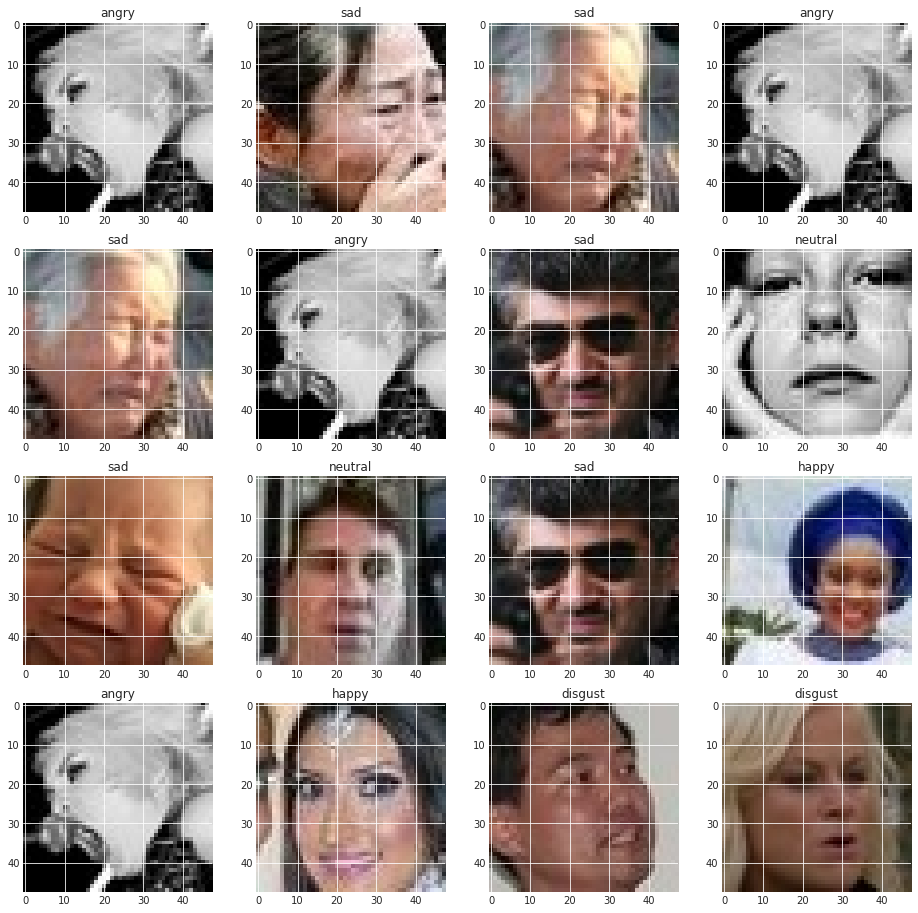

In [19]:
# define a function 
def show_examples(image,label,idx):
    # create 4x4 figure
    fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(16,16))
    # loop through each figure
    for idx_f,ax in zip(idx,axes.ravel()):
        # add image to figure
        ax.imshow(image[idx_f].squeeze(),cmap="gray")
        # add title to each figure
        ax.set_title(label_to_text[label[idx_f]])
    plt.show()
idx=np.random.choice(16,16)
show_examples(image_array,Y_train,idx)

In [20]:
# now we will start with our model
# import all library required for model
from keras import layers,callbacks,utils,applications,optimizers
from keras.models import Sequential,Model,load_model
# run this block

In [21]:
model=Sequential()
# I will use MobileNetV2 as an pretrained model 
pretrained_model=applications.MobileNetV2(input_shape=(48,48,3),include_top=False,
                                         weights="imagenet")
# you can use other pretrained model to increase accuracy or increase frame rate
# change all non-trainable layer to trainable
pretrained_model.trainable=True
# add pretrained_model to model
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
# add dropout to increase accuracy by not overfitting
model.add(layers.Dropout(0.3))
# add dense layer as final output
model.add(layers.Dense(1))
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [23]:
from tensorflow.keras.optimizers import Adam

In [24]:
#compile model

model.compile(optimizer=Adam(0.0001),loss="mean_squared_error",metrics=["mae"])
# run
# starting learning rate is 1e-3
# you can change optimizer, loss function, metrics for better result

In [25]:
# create a model checkpoint to save model
ckp_path="trained_model/model"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                   monitor="val_mae",
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="auto")
# this checkpoint save model when val_mae is lower then best val_mae
#run
                                                    

In [26]:
# now we will define learning rate reducer 
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(factor=0.9,
                                              monitor="val_mae",
                                              mode="auto",
                                              cooldown=0,
                                              patience=5,
                                              verbose=1,
                                              min_lr=1e-6)
# this will decrease learning rate when val_mae does't decrease durning last 5 epoch
# verbose is use to show val_mae every epoch


In [27]:
EPOCHS=300
BATCH_SIZE=64
# start training
history=model.fit(image_array,Y_train,
                 validation_data=(X_test,Y_test),
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[model_checkpoint,reduce_lr])
#run

Epoch 1/300
999/999 [==============================] - 33s 24ms/step - loss: 5.0736 - mae: 1.7991 - val_loss: 27.8209 - val_mae: 4.8689
Epoch 2/300
999/999 [==============================] - 23s 23ms/step - loss: 2.7991 - mae: 1.3356 - val_loss: 3.9017 - val_mae: 1.5674
Epoch 3/300
999/999 [==============================] - 23s 23ms/step - loss: 2.3808 - mae: 1.2155 - val_loss: 2.3831 - val_mae: 1.1964
Epoch 4/300
999/999 [==============================] - 23s 23ms/step - loss: 2.1329 - mae: 1.1400 - val_loss: 2.2840 - val_mae: 1.1645
Epoch 5/300
999/999 [==============================] - 23s 23ms/step - loss: 1.9070 - mae: 1.0695 - val_loss: 2.4471 - val_mae: 1.1906
Epoch 6/300
999/999 [==============================] - 23s 23ms/step - loss: 1.8312 - mae: 1.0397 - val_loss: 2.1658 - val_mae: 1.1140
Epoch 7/300
999/999 [==============================] - 23s 23ms/step - loss: 1.5693 - mae: 0.9562 - val_loss: 2.1502 - val_mae: 1.1033
Epoch 8/300
999/999 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



999/999 [==============================] - 23s 23ms/step - loss: 0.3920 - mae: 0.4683 - val_loss: 2.2959 - val_mae: 1.0572
Epoch 23/300
999/999 [==============================] - 22s 22ms/step - loss: 0.3534 - mae: 0.4440 - val_loss: 2.3396 - val_mae: 1.0630
Epoch 25/300
999/999 [==============================] - 23s 23ms/step - loss: 0.3549 - mae: 0.4440 - val_loss: 2.3146 - val_mae: 1.0624
Epoch 26/300
999/999 [==============================] - 23s 23ms/step - loss: 0.3208 - mae: 0.4216 - val_loss: 2.2114 - val_mae: 1.0337
Epoch 27/300
999/999 [==============================] - 23s 23ms/step - loss: 0.3022 - mae: 0.4092 - val_loss: 2.2038 - val_mae: 1.0317
Epoch 28/300
999/999 [==============================] - 23s 23ms/step - loss: 0.3026 - mae: 0.4083 - val_loss: 2.1766 - val_mae: 1.0304
Epoch 29/300
999/999 [==============================] - 23s 23ms/step - loss: 0.2877 - mae: 0.3991 - val_loss: 2.1544 - val_mae: 1.0108
Epoch 30/300
999/999 [==============================] - 23s 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



999/999 [==============================] - 22s 23ms/step - loss: 0.0144 - mae: 0.0845 - val_loss: 1.9597 - val_mae: 0.8664

Epoch 00235: ReduceLROnPlateau reducing learning rate to 6.461081602537889e-06.
Epoch 236/300
999/999 [==============================] - 22s 22ms/step - loss: 0.0153 - mae: 0.0850 - val_loss: 1.9467 - val_mae: 0.8659
Epoch 237/300
999/999 [==============================] - 22s 22ms/step - loss: 0.0160 - mae: 0.0857 - val_loss: 1.9609 - val_mae: 0.8693
Epoch 238/300
999/999 [==============================] - 23s 23ms/step - loss: 0.0148 - mae: 0.0853 - val_loss: 1.9552 - val_mae: 0.8702
Epoch 239/300
999/999 [==============================] - 23s 23ms/step - loss: 0.0157 - mae: 0.0854 - val_loss: 1.9682 - val_mae: 0.8788
Epoch 240/300
999/999 [==============================] - 22s 22ms/step - loss: 0.0150 - mae: 0.0845 - val_loss: 1.9613 - val_mae: 0.8706

Epoch 00240: ReduceLROnPlateau reducing learning rate to 5.814973565065884e-06.
Epoch 241/300
999/999 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [37]:
# after training is finished 
# load best model
model.load_weights(ckp_path)

In [38]:
# if you want to see result
prediction_val=model.predict(X_test,batch_size=BATCH_SIZE)


In [39]:
# prediction value 
prediction_val[:10]

array([[1.231234  ],
       [2.9925222 ],
       [3.8563342 ],
       [2.9334726 ],
       [3.4559126 ],
       [0.22541174],
       [2.1532502 ],
       [3.4609165 ],
       [3.1963277 ],
       [3.1107497 ]], dtype=float32)

In [40]:
# original value
Y_test[:10]

array([0, 4, 4, 2, 6, 0, 3, 4, 4, 2])

In [41]:
# now convert model to tensorflow lite model 
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

#save model 
with open("model.tflite","wb") as f:
    f.write(tflite_model)